# Visualizing the Interpretation of Least-Squares Confidence Intervals

Least-squares estimation is a "frequentist inference" technique. For a single sample  of some process (an "event"), the frequentist interpretation of probability says that the probability of obtaining that single sample is related equivalent to the relative frequency of obtaining that sample given many the ability to hypothetically perform a very large number of samples.

This is why the the interpretation of a confidence interval from frequentist statistics perspective is usually stated to be something like: 

>For a 68% confidence interval: If we could hypothetically make and infinite set of new measurements and fit each of those, 68\% of the time the 'true' value of the parameter would lie within the CI.

So there it is in words, but what does this "look" like? Let's visualize this statement:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot
font = {'size'   : 18}
matplotlib.rc('font', **font)
import corner
# set the random seed; get the same results each time we run this notebook
seed = sum([ord(x) for x in 'isrschool'])
np.random.seed(seed)

## The Truth

Let's define a truth linear model, with some true slope and true y-intercept:

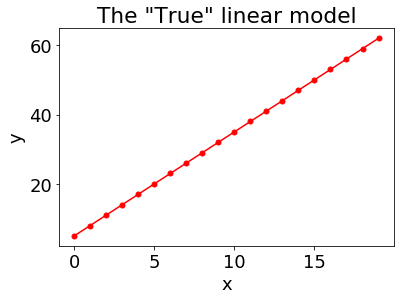

In [2]:
# Truth model
x = np.arange(0,20)
m_true = 3.0
b_true = 5.0

y_true = m_true*x+b_true
fig = pyplot.figure()
ax = fig.add_subplot(111)
l = ax.plot(x,y_true,'r.-',ms=10)
l = ax.set_xlabel('x')
l = ax.set_ylabel('y')
l = ax.set_title('The "True" linear model')

## The Sampling a Random Process

Now let's assume that we are sampling some random process that has some "truth" given by the linear model we defined above. For example, we might be trying to take measurements of electron density using an incoherent scatter radar. There exists some "true" value for the electron density that nature knows and we are trying to discern.

Normally, you can only take one sample, but here we defined the truth; we are nature and we can now take a very large number of samples: an ensemble of samples.

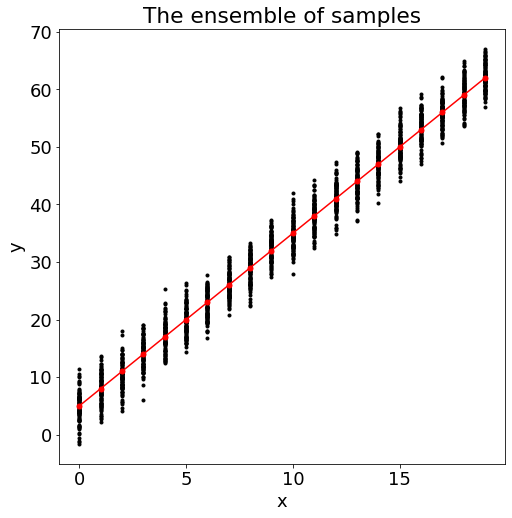

In [3]:
# Number of samples in the ensemble
N  = 10000

# Measurment errors (Gaussian!)
sigma = 2.5  
errs = sigma*np.random.randn(x.shape[0],N)

# Ensemble of samples
X = np.repeat(x[:,np.newaxis],N,axis=1)
y_data = m_true * X + b_true + errs

# Plot the ensembles
fig = pyplot.figure(figsize=(8,8))
ax = fig.add_subplot(111)
l = ax.plot(x,y_data[:,:100],'k.',zorder=1) # only plot 100 samples
l = ax.plot(x,y_true,'r.-',ms=10,zorder=10)
l = ax.set_xlabel('x')
l = ax.set_ylabel('y')
l = ax.set_title('The ensemble of samples')

## Perform a Linear Least-Squares Fit

For a linear forward model:

$ \mathbf{z} = H\mathbf{p} + \mathbf{e}$

we know that the least-squares solution in general is given by:

$\hat{\mathbf{p}}_{LS} = \left[H^T\mathbf{\Sigma}_e^{-1}H\right]^{-1}H^T \mathbf{\Sigma}_e^{-1} \mathbf{z}$

and the covariance of the fitted parameters is:

$\mathbf{\Sigma}_{\hat{\mathbf{p}}_{\rm LS}} = \left[H^T \mathbf{\Sigma}_{e}^{-1} H\right]^{-1}$

So now we'll perform a fit to each sample in our ensemble and then we'll plot the slope and y-intercept that we obtain for each fit (we'll plot an ensemble of fitted parameters):

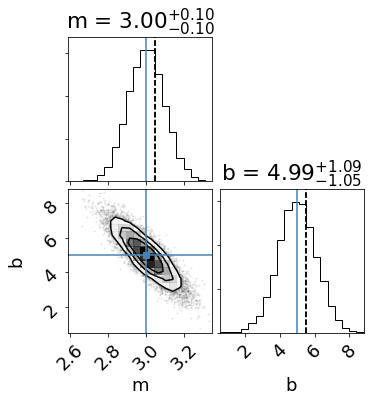

In [4]:
# Simple least squares fit
H = np.matrix([x,np.ones(x.shape[0])]).T
phat = np.zeros((2,N))
for i in range(N):
    phat[:,i]=np.linalg.inv(H.T@H)@H.T@y_data[:,i]
    
fig = corner.corner(phat.T,bin=41,show_titles=True,labels=['m','b'],truths=[m_true,b_true],quantiles=[0.68,0.68])

## Construct the Confidence Intervals For Each Fit

Now we will construct a confidence interval for each parameter of each fit. As a reminder, a confidence interval for parameter $p_m$ is calculated using:

$\delta p_m = \pm \sqrt{\Delta \chi^2} \sqrt{ \Sigma_{mm}}$

where $\Delta \chi^2=1$ for a 68% confidence interval. The covariance matrix for each fit was:

In [5]:
#Covariance Matrix
cov_phat = sigma**2 * np.linalg.inv(H.T@H)
print(cov_phat)

[[ 0.0093985  -0.08928571]
 [-0.08928571  1.16071429]]


so now we'll use the diagonal elements of the covariance matrix to build a confidence interval for each fitted $m$ and $b$. Then, we will count proportion of confidence intervals that contain the true $m$ and $b$ values:

In [6]:
# Confidence intervals for slope and y-intercept
m_low = phat[0,:] - np.sqrt(cov_phat[0,0])
m_high = phat[0,:] + np.sqrt(cov_phat[0,0])
b_low = phat[1,:] - np.sqrt(cov_phat[1,1])
b_high = phat[1,:] + np.sqrt(cov_phat[1,1])

# Now let's see how many of these N intervals contain the true values
num_m_intervals = np.where((m_low < m_true) & (m_high > m_true))[0].size
num_b_intervals = np.where((b_low < b_true) & (b_high > b_true))[0].size

# And now let's print the proportion of intervals containing the true values
print("%0.3f %% of the %d confidence intervals contain the true value for the slope" % (100*(num_m_intervals/N),N))
print("%0.3f %% of the %d confidence intervals contain the true value for the y-intercept" % (100*(num_b_intervals/N),N))

68.340 % of the 10000 confidence intervals contain the true value for the slope
68.130 % of the 10000 confidence intervals contain the true value for the y-intercept
